In [1]:
import os
import pandas as pd
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,utils, datasets as ds
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import cv2

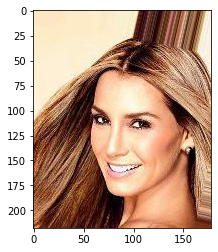

In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)
train_set = tv.datasets.ImageFolder(root='visualize', transform=transform)
data_loader = DataLoader(dataset=train_set)

to_pil_image = transforms.ToPILImage()

for image, label in data_loader:

    # 方法1：Image.show()
    # transforms.ToPILImage()中有一句
    # npimg = np.transpose(pic.numpy(), (1, 2, 0))
    # 因此pic只能是3-D Tensor，所以要用image[0]消去batch那一维
    img = to_pil_image(image[0])
    img.show()
    # 显示图片
plt.imshow(img)
plt.show()

In [3]:
class FaceDataset(Dataset):
    def __init__(self, csv_file, txt_file, root_dir, transform=None):
        self.index = pd.read_csv(csv_file)
        self.labels = np.loadtxt(txt_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        
        img_name = os.path.join(self.root_dir, self.index.iloc[idx, 0])
        image = io.imread(img_name)
        image = image.astype('float')
        labels = self.labels[idx]
        labels = labels.astype('long').reshape(-1)
        sample = {'image':image, 'label':labels}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = np.transpose(image, (2, 0, 1))
        label = (label + 1) / 2
        return {'image':torch.FloatTensor(image),
                 'label':torch.LongTensor(label)}

In [4]:
transformed_dataset = FaceDataset(csv_file='visualize/test.csv', txt_file='visualize/test.txt',
                                  root_dir='visualize/', transform=transforms.Compose([
    ToTensor()
]))
#print(len(self.labels))
train_size = 1
test_size = 1
batch_size = 1

dataloader = DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True)
train_dataset, test_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, test_size])
#train_dataset = transformed_dataset
#train_loader = DataLoader(train, batch_size=1,  shuffle=False, num_workers=5)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_size, shuffle=False)

In [5]:
print(train_dataset[0])


{'image': tensor([[[253., 253., 253.,  ..., 247., 254., 254.],
         [253., 253., 253.,  ..., 249., 254., 254.],
         [253., 253., 253.,  ..., 250., 255., 255.],
         ...,
         [140., 116., 146.,  ..., 122., 122., 122.],
         [130., 138., 166.,  ..., 118., 118., 118.],
         [168., 204., 245.,  ..., 118., 120., 120.]],

        [[231., 231., 231.,  ..., 226., 238., 238.],
         [231., 231., 231.,  ..., 228., 238., 238.],
         [231., 231., 231.,  ..., 231., 239., 239.],
         ...,
         [ 74.,  48.,  78.,  ...,  55.,  56.,  56.],
         [ 62.,  70.,  98.,  ...,  49.,  51.,  51.],
         [100., 136., 177.,  ...,  49.,  50.,  50.]],

        [[194., 194., 194.,  ..., 225., 222., 222.],
         [194., 194., 194.,  ..., 225., 222., 222.],
         [194., 194., 194.,  ..., 227., 223., 223.],
         ...,
         [ 26.,   1.,  33.,  ...,  28.,  30.,  30.],
         [ 15.,  23.,  53.,  ...,  20.,  24.,  24.],
         [ 53.,  89., 132.,  ...,  20.,  24

In [5]:
# 建立卷积神经网络模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5, 1)
        self.conv2 = nn.Conv2d(10, 20, 4, 1)
        self.conv3 = nn.Conv2d(20, 50, 3, 1)
        self.fc1 = nn.Linear(25*20*50, 10000)
        self.fc2 = nn.Linear(10000, 1000)
        self.fc3 = nn.Linear(1000, 100)
        self.fc4 = nn.Linear(100, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        y1 = x.detach().numpy()#(1,10,214,174)
        y1 = y1.astype(int)
        #y = y[:,:1,2,3]
        y1 = y1.reshape(214*5, 174*2)       
        plt.rcParams['figure.figsize'] = (10,20)
        #plt.imshow(y, cmap='gray')
        plt.imshow(y1)
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        #y2 = x.detach().numpy()#(1, 20, 104, 84)
        #y2 = y2.astype(int)
        #y2 = y2.reshape(104*5,84*4)
        #plt.rcParams['figure.figsize'] = (10,20)
        #plt.imshow(y2)
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        #y3 = x.detach().numpy()#(1, 50, 50, 40)
        #y3 = y3.astype(int)
        #y3 = y3.reshape(50*10,50*4)
        #plt.rcParams['figure.figsize'] = (10,20)
        #plt.imshow(y3)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 25*20*50)
        x = F.relu(self.fc1(x))
        #y = x.detach().numpy()
        #y = y.astype(int)
        #plt.imshow(y)
        #print(y.shape)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        #plt.subplot(1,3,1)
        #plt.imshow(y1)
        #plt.subplot(1,3,2)
        #plt.imshow(y2)
        #plt.subplot(1,3,3)
        #plt.imshow(y3)
        
        return F.log_softmax(x,dim=1)

In [6]:
# 设置参数、模型、优化器
lr = 0.01
momentum = 0.5
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
num_epochs = 1

In [7]:
# 训练函数
def train(model, train_loader, optimizer, epoch):
    model.train()
    for idx, sample in enumerate(train_loader): # idx:字典的批序号，sample:第idx批字典
        data = sample['image'] # data:tensor格式float32, 30 * 3 * 94 * 94
        target = sample['label'].view(-1) # target:tensor格式， 30 * 1
        data = torch.tensor(data, dtype=torch.float32)
        pred = model(data) # pred:tensor格式， 30 * 1
        loss = F.nll_loss(pred, target) # loss:tensor格式标量
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #torch.save(the_model,'D:/ELEC0134 Applied Machine Learning Systems/assignment/AMLS_assignment_kit/AMLS_20-21_SN12345678/A2')
        print("Train Epoch:{}, iteration:{}, Loss:{}".format(epoch, idx, loss.item()))

In [8]:
# 测试函数
def test(model, test_loader):
    model.eval()
    total_loss = 0.
    correct = 0.
    with torch.no_grad():
        for idx, sample in enumerate(test_loader): # idx:字典的批序号，sample:第idx批字典
            data = sample['image'] # data:tensor格式float32, 1 * 3 * 94 * 94
            target = sample['label'].view(-1) # target:tensor格式标量
            data = torch.tensor(data, dtype=torch.float32)
            output = model(data) # output:tensor格式标量
            total_loss = F.nll_loss(output, target, reduction = 'sum').item() # total_loss:tensor格式标量
            pred = output.argmax(dim = 1)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    total_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset) * 100
    print("Test Loss:{}, Test Accuracy:{}".format(total_loss, acc))

1


D:\Anaconda\envs\lab1\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Train Epoch:0, iteration:0, Loss:0.6657066941261292


D:\Anaconda\envs\lab1\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Test Loss:0.0, Test Accuracy:100.0


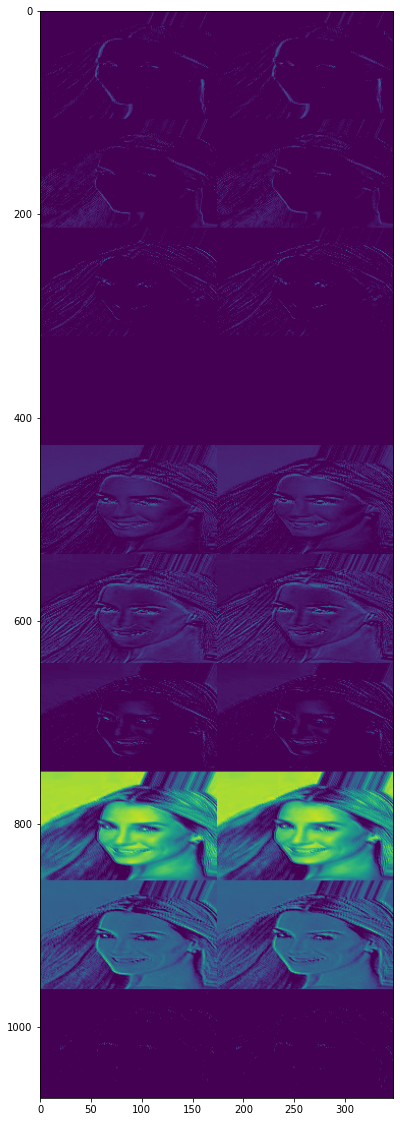

In [9]:
print(len(train_loader))
#min_loss = 100000#随便设置一个比较大的数
for epoch in range(num_epochs):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)
    #loss[epoch] = loss.item()

#    val_loss = loss
#    if val_loss < min_loss:
#        min_loss = val_loss
#        print("save model")
#        torch.save(model,'smiling.pt')
#torch.save(model, 'smiling.pt')

In [111]:
model.parameters

# retrieve weights from the first convolutional layer
filters, biases = model.layers[0].get_weights()
print('filter sizes : ', filters.shape)

# normalize filter values
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = filters.shape[3]
for i in range(n_filters):
    f = filters[:, :, :, i]
    for j in range(f.shape[2]):
        plt.subplot(2, 3, i+1)
        plt.imshow(f[:, :, j], cmap='gray')
        plt.axis('off')

<bound method Module.parameters of Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=25000, out_features=10000, bias=True)
  (fc2): Linear(in_features=10000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=2, bias=True)
)>

In [120]:
print(model.parameters())
print(model.parameters)
print(model.named_parameters())
print(model.named_parameters)
#model.parameters[0].get_weights

<generator object Module.parameters at 0x00000221B83519E8>
<bound method Module.parameters of Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=25000, out_features=10000, bias=True)
  (fc2): Linear(in_features=10000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=2, bias=True)
)>
<generator object Module.named_parameters at 0x00000221B83519E8>
<bound method Module.named_parameters of Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=25000, out_features=10000, bias=True)
  (fc2): Linear(in_features=10000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_

<bound method Module.parameters of Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=25000, out_features=10000, bias=True)
  (fc2): Linear(in_features=10000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=2, bias=True)
)>


TypeError: 'method' object is not iterable